## Introduction
The S&P 500 (Standard & Poor's 500) is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as one of the best representations of the U.S. stock market and economy. Over the long term, the S&P 500 has shown consistent growth, making it a key focus for long-term investors. However, it can also experience significant volatility in the short term.

In this project, we will make our first attempt to build a momentum-based strategy to trade the S&P 500 index. At the end of the project, you will have built a program that you can later expand and customise to suit your needs. We will use the python packages numpy, scipy and sqlite3, among others, in this project.

Tips: Review the code snippets that we went through during the course. Reorganize them and you are half-way done! Try experimenting with different configurations of the confidence interval, the lookback window and the forecast horizon. Be brave and experiment with different ways of deciding the position size. You may be surprised by your talent!

Re-organize your code from the exercises into a Python program that 
1. read prices from a database
2. calibrate a GBM model on each day when new prices are received.
3. forecast the price in e.g. 10 days and
   1. calculate the confidence interval of the forecast
   2. calculate the expected shortfall from the price forecast
4. code your trading signals using the price forecast and the expected shortfall.
5. store your postions into the *positions* table after each trade.
6. produce a 1-year backtest record from 2020-06-01 to 2021-05-31.

1. Collect all the code related to the GBM model into a class

In [22]:
# Appears 'prices' table exists but has no data - writing to it using yfinance data:

In [23]:
import sqlite3
import yfinance as yf

conn = sqlite3.connect("SP500.db")
cs = conn.cursor()

# Recreate prices table
cs.execute("DROP TABLE IF EXISTS prices;")
cs.execute("""
    CREATE TABLE prices (
        date TEXT PRIMARY KEY,
        price REAL
    );
""")

# Download SPY data
data = yf.download("SPY", start="2019-01-01", end="2022-01-01")

# Loop through the index
for date, row in data.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    adj_close = float(row["Close"])
    cs.execute("INSERT INTO prices (date, price) VALUES (?, ?);", (date_str, adj_close))

conn.commit()
print("Loaded prices into SP500.db")


/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/1606458228.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2019-01-01", end="2022-01-01")
[*********************100%***********************]  1 of 1 completed

Loaded prices into SP500.db



/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/1606458228.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  adj_close = float(row["Close"])


In [24]:
# Sanity check
cs.execute("SELECT MIN(date), MAX(date), COUNT(*) FROM prices;")
print(cs.fetchone())

('2019-01-02', '2021-12-31', 757)


In [25]:
import csv
from contextlib import closing
from datetime import datetime

import numpy as np
from scipy.stats import norm


In [26]:
class GBM:
    def __init__(self):
        self.mu, self.sigma = [np.nan, np.nan]

    def simulate(self, N, K, Dt, S0):
        # Simulate K trajectories over N steps of size Dt, starting from S0
        traj = np.empty((N + 1, K))
        traj[0] = S0
        Z = np.random.normal(size=(N, K))
        drift = (self.mu - 0.5 * self.sigma**2) * Dt
        diffusion = self.sigma * np.sqrt(Dt) * Z

        for t in range(1, N + 1):
            traj[t] = traj[t - 1] * np.exp(drift + diffusion[t - 1])

        return traj

    def calibrate(self, prices, Dt):
        log_returns = np.diff(np.log(prices))
        self.mu = np.mean(log_returns) / Dt
        self.sigma = np.std(log_returns) / np.sqrt(Dt)


    def forecast(self, latest, T, confidence):
        mu_hat = self.mu - 0.5 * self.sigma**2
        mean = np.log(latest) + mu_hat * T
        std = self.sigma * np.sqrt(T)
        z = norm.ppf((1 + confidence) / 2)
        lower = np.exp(mean - z * std)
        upper = np.exp(mean + z * std)
        expected_price = np.exp(mean)
        return (expected_price, lower, upper)

    def expected_shortfall(self, T, confidence):
        z = norm.ppf((1 + confidence) / 2)
        std = self.sigma * np.sqrt(T)
        return z * std

In [27]:
# Test
model = GBM()
model.mu = 0.3
model.sigma = 0.2
simulated = model.simulate(500, 1, 1/250, 100)
simulated = simulated[:, 0]

model2 = GBM()
model2.calibrate(simulated, 1/250)

print(F"Calibrated: mu = {model2.mu}, sigma = {model2.sigma}")



Calibrated: mu = 0.48001750988682934, sigma = 0.1978773576204094


2. Write a function that prepares the database for trading, i.e.
   1. load the historical prices into the *prices* table
   2. create the *positions* table
   3. initialize the *positions* table with the your initial cash reserve. The initial *time_of_trade* can be any date before the earliest possible trading date.

    Call this function *prepare*.

In [29]:
def prepare():
    # Create prices table and load SPY data
    cs.execute("DROP TABLE IF EXISTS prices")
    cs.execute("""
        CREATE TABLE prices (
            date TEXT PRIMARY KEY,
            price REAL
        )
    """)

    print("Downloading SPY price data...")
    data = yf.download("SPY", start="2019-01-01", end="2022-01-01")

    for date, row in data.iterrows():
        date_str = date.strftime('%Y-%m-%d')
        price = float(row["Close"])
        cs.execute("INSERT INTO prices (date, price) VALUES (?, ?);", (date_str, price))

    # Create and seed the positions table
    cs.execute("DROP TABLE IF EXISTS positions")
    cs.execute("""
        CREATE TABLE positions (
            time_of_trade TEXT,
            position INTEGER,
            cash REAL
        )
    """)
    cs.execute("INSERT INTO positions VALUES (?, ?, ?)", ("1900-01-01", 0, 1_000_000))

    conn.commit()


In [30]:
prepare()

/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2019-01-01", end="2022-01-01")
[*********************100%***********************]  1 of 1 completed


/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(row["Close"])


In [31]:
# Test
prepare()
latest_prices = cs.execute("select * from prices order by date desc limit 10")
for item in latest_prices:
    print(item)

/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2019-01-01", end="2022-01-01")
[*********************100%***********************]  1 of 1 completed

('2021-12-31', 451.85064697265625)
('2021-12-30', 452.9924011230469)
('2021-12-29', 454.2481384277344)
('2021-12-28', 453.66778564453125)
('2021-12-27', 454.0387878417969)
('2021-12-23', 447.702880859375)
('2021-12-22', 444.9344482421875)
('2021-12-21', 440.5296936035156)
('2021-12-20', 432.84283447265625)
('2021-12-17', 437.49493408203125)



/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(row["Close"])


3. Write a function that determines the trade size, i.e. how many units of the instrument you would like to own when the date is *which_day* and the price forecast of the instrument is *forecast* and the expected shortfall from the same forecast is *ES*.

In [33]:
def position_size(which_day, forecast, ES):
    """
    Determine how many units to trade based on forecast and expected shortfall.
    """
    if any(map(np.isnan, [forecast, ES])):
        return 0
    
    price_today = cs.execute("SELECT price FROM prices WHERE date = ?", (which_day,)).fetchone()
    if price_today is None:
        return 0

    price_today = price_today[0]
    expected_gain = forecast - price_today

    # NEW: Check for NaN inputs
    if any(map(np.isnan, [forecast, ES, expected_gain])):
        return 0

    if expected_gain <= 0 or ES <= 0:
        return 0

    CONFIDENCE_MULTIPLIER = 100
    size = int(CONFIDENCE_MULTIPLIER * expected_gain / ES)
    return size


4. Write a function that, for a given date, calibrates a GBM model to the data prior to that date and that forecasts the price in 10 days. Call this function *analyse*.

In [35]:
def analyse(which_day):
    cs.execute("SELECT price FROM prices WHERE date < ? ORDER BY date", (which_day,))
    rows = cs.fetchall()
    
    if len(rows) < 2:
        return (np.nan, np.nan)

    prices = np.array([row[0] for row in rows], dtype=float)

    # Ensure 1D input to calibrate
    prices = prices.flatten()

    gbm = GBM()
    Dt = 1 / 252
    gbm.calibrate(prices, Dt)  # <<— important that it's 1D!

    latest_price = prices[-1]
    T = 10 / 252
    forecast = gbm.forecast(latest_price, T, confidence=0.95)
    ES = gbm.expected_shortfall(T, confidence=0.95)

    return forecast, ES


In [36]:
# Test the analyse function
test_dates = ['2021-05-09', '2021-05-14']
positions = [np.nan, np.nan]
for i in range(2):
    positions[i] = analyse(test_dates[i])
    print(F"{positions[i]} shares advised on {test_dates[i]}.")

((400.9461660665239, 364.9915096834345, 440.44265090679374), 0.09395307691300218) shares advised on 2021-05-09.
((389.48906525876316, 354.57154900397285, 427.8451905751899), 0.09392563476081162) shares advised on 2021-05-14.


In [37]:
cs.execute("SELECT COUNT(*) FROM prices WHERE date < '2021-05-09'")
print(cs.fetchone())

cs.execute("SELECT COUNT(*) FROM prices WHERE date < '2021-05-14'")
print(cs.fetchone())


(592,)
(596,)


5. The main loop of the program: Loop over the dates in the backtest period and use the *analyse* function to decide what to do on each day. Call this function *main*.

In [39]:
def main(begin_on):
    import math

    # Get all trading days starting from the given date
    cs.execute("SELECT date FROM prices WHERE date >= ?;", (begin_on,))
    days = [d[0] for d in cs.fetchall()]

    # Clear any existing trades beyond the starting point
    cs.execute("DELETE FROM positions WHERE time_of_trade > ?", (begin_on,))

    for d in days:
        # Get most recent known position and cash before today
        cs.execute("""
            SELECT position, cash FROM positions
            WHERE time_of_trade <= ?
            ORDER BY time_of_trade DESC
            LIMIT 1;
        """, (d,))
        result = cs.fetchone()
        if result:
            asset_old, cash_old = result
        else:
            asset_old, cash_old = 0, 1_000_000  # fallback

        # Run forecast and expected shortfall
        forecast_tuple, ES = analyse(d)
        forecast_price = forecast_tuple[0] if forecast_tuple else np.nan

        # Get latest known price (today’s price or earlier)
        cs.execute("""
            SELECT price FROM prices
            WHERE date <= ?
            ORDER BY date DESC
            LIMIT 1;
        """, (d,))
        latest_price_row = cs.fetchone()
        if latest_price_row is None:
            continue  # no price available, skip this date

        latest_price = latest_price_row[0]

        # Skip days with invalid forecast
        if any(map(np.isnan, [forecast_price, ES, latest_price])):
            continue

        # Get new advised position
        asset_new = position_size(d, forecast_price, ES)

        # Calculate trade size and new cash
        trade_size = asset_new - asset_old
        cash_new = cash_old - trade_size * latest_price

        # Save the trade
        cs.execute("""
            INSERT INTO positions (time_of_trade, position, cash)
            VALUES (?, ?, ?);
        """, (d, asset_new, cash_new))

    conn.commit()


6. Connect to the database and create a *cursor* object associated with the connection. Share the connection and the cursor object across the program so that you don't have to connect to and disconnect from the database in every function of the program.

In [41]:
if __name__ == "__main__":
    with closing(sqlite3.connect("SP500.db")) as conn:
        with closing(conn.cursor()) as cs:
            prepare()
            main('2020-06-01')
    


/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2019-01-01", end="2022-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(row["Close"])


In [42]:
# plot your track record
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()

day1 = '2020-06-01'
day1_dt = datetime.strptime(day1, '%Y-%m-%d')

cs.execute(f"""
    select date, position * price + cash as wealth
    from positions as PO
    join prices as PR
    on PO.time_of_trade = (
        select time_of_trade from positions
        where time_of_trade <= PR.date
        order by time_of_trade desc limit 1
    )
    where date >= '{day1}';
""")

records = cs.fetchall()

def calculate_T(record, day1_dt):
    date, wealth = record
    date_dt = datetime.strptime(date, '%Y-%m-%d')
    T = (date_dt - day1_dt).days
    return (T, wealth)

records = [calculate_T(record, day1_dt) for record in records]
W = np.array(records, dtype=float).reshape(-1, 2)

/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2019-01-01", end="2022-01-01")
[*********************100%***********************]  1 of 1 completed


/var/folders/v4/sm00xvsd7l3cn1whnf5h88ww0000gn/T/ipykernel_29815/3825139263.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(row["Close"])


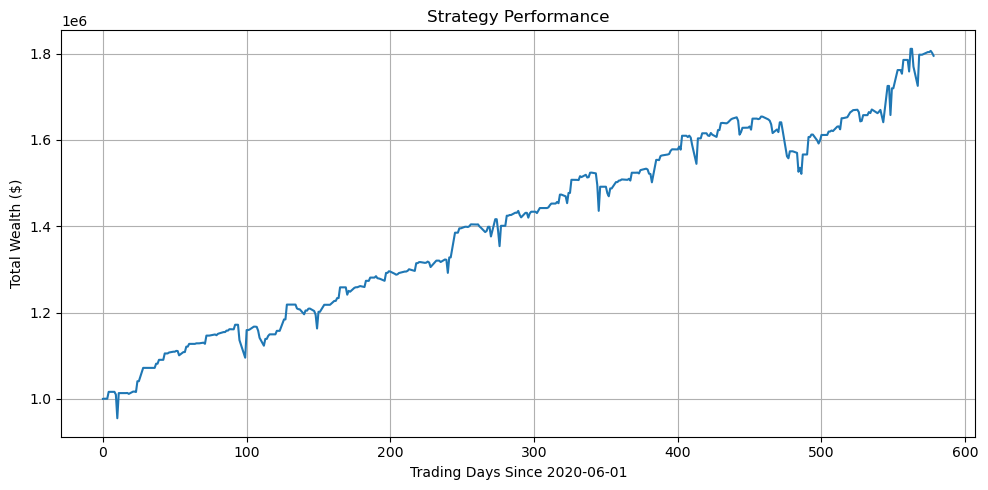

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

prepare()
main("2020-06-01")

conn = sqlite3.connect("SP500.db")
cs = conn.cursor()

# Get all prices and match with most recent known position
cs.execute("""
    SELECT PR.date, PR.price,
           (SELECT position FROM positions
            WHERE time_of_trade <= PR.date
            ORDER BY time_of_trade DESC
            LIMIT 1) as position,
           (SELECT cash FROM positions
            WHERE time_of_trade <= PR.date
            ORDER BY time_of_trade DESC
            LIMIT 1) as cash
    FROM prices PR
    WHERE PR.date >= '2020-06-01'
    ORDER BY PR.date;
""")

rows = cs.fetchall()

# Convert to wealth
wealth_records = []
start_date = datetime.strptime("2020-06-01", "%Y-%m-%d")
for row in rows:
    date_str, price, position, cash = row
    if None in (price, position, cash):
        continue
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    T = (dt - start_date).days
    wealth = position * price + cash
    wealth_records.append((T, wealth))

W = np.array(wealth_records)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(W[:, 0], W[:, 1])
plt.xlabel("Trading Days Since 2020-06-01")
plt.ylabel("Total Wealth ($)")
plt.title("Strategy Performance")
plt.grid(True)
plt.tight_layout()
plt.show()
